# Introduction
本项目使用`Inception V3`和`ResNet50`两个预训练模型的特征提取能力来识别狗品种。

## Methods：
- **预处理**：输入图像进行缩放以确保统一的尺寸。应用数据增强技术，例如以 0.2 的概率进行水平和垂直翻转，以增加训练数据的多样性并提高模型泛化能力。  
- **特征提取**：使用 Inception V3 和 ResNet50 预训练模型从输入图像中提取高级特征。  
- **分类器层**：提取的特征被输入到具有 0.7 丢弃率的分类器层。  
- **训练**：使用学习率为 0.005 的 SGD 优化算法和交叉熵损失进行模型训练。训练过程中，对分类器层进行微调，同时冻结预训练模型的参数。  
- **评估**：根据验证准确率和损失指标来评估模型的性能。  

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score, precision_recall_curve, average_precision_score


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms

In [2]:
# %pip install --upgrade seaborn

配置GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check Data

读取数据

In [4]:
df = pd.read_csv("/kaggle/input/dog-breed-identification-data/labels.csv")
print(f'Train_data shape：{df.shape}')
df.head()

Train_data shape：(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


获取所有标签

In [5]:
dog_breeds = sorted(df['breed'].unique())
print(f'Number of unique breed：{len(dog_breeds)}\n')
print(dog_breeds)
breed_classes = df.breed.value_counts().reset_index()
breed_classes['count'].describe()

Number of unique breed：120

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_set

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: count, dtype: float64

# Data Visualization

统计所有种类

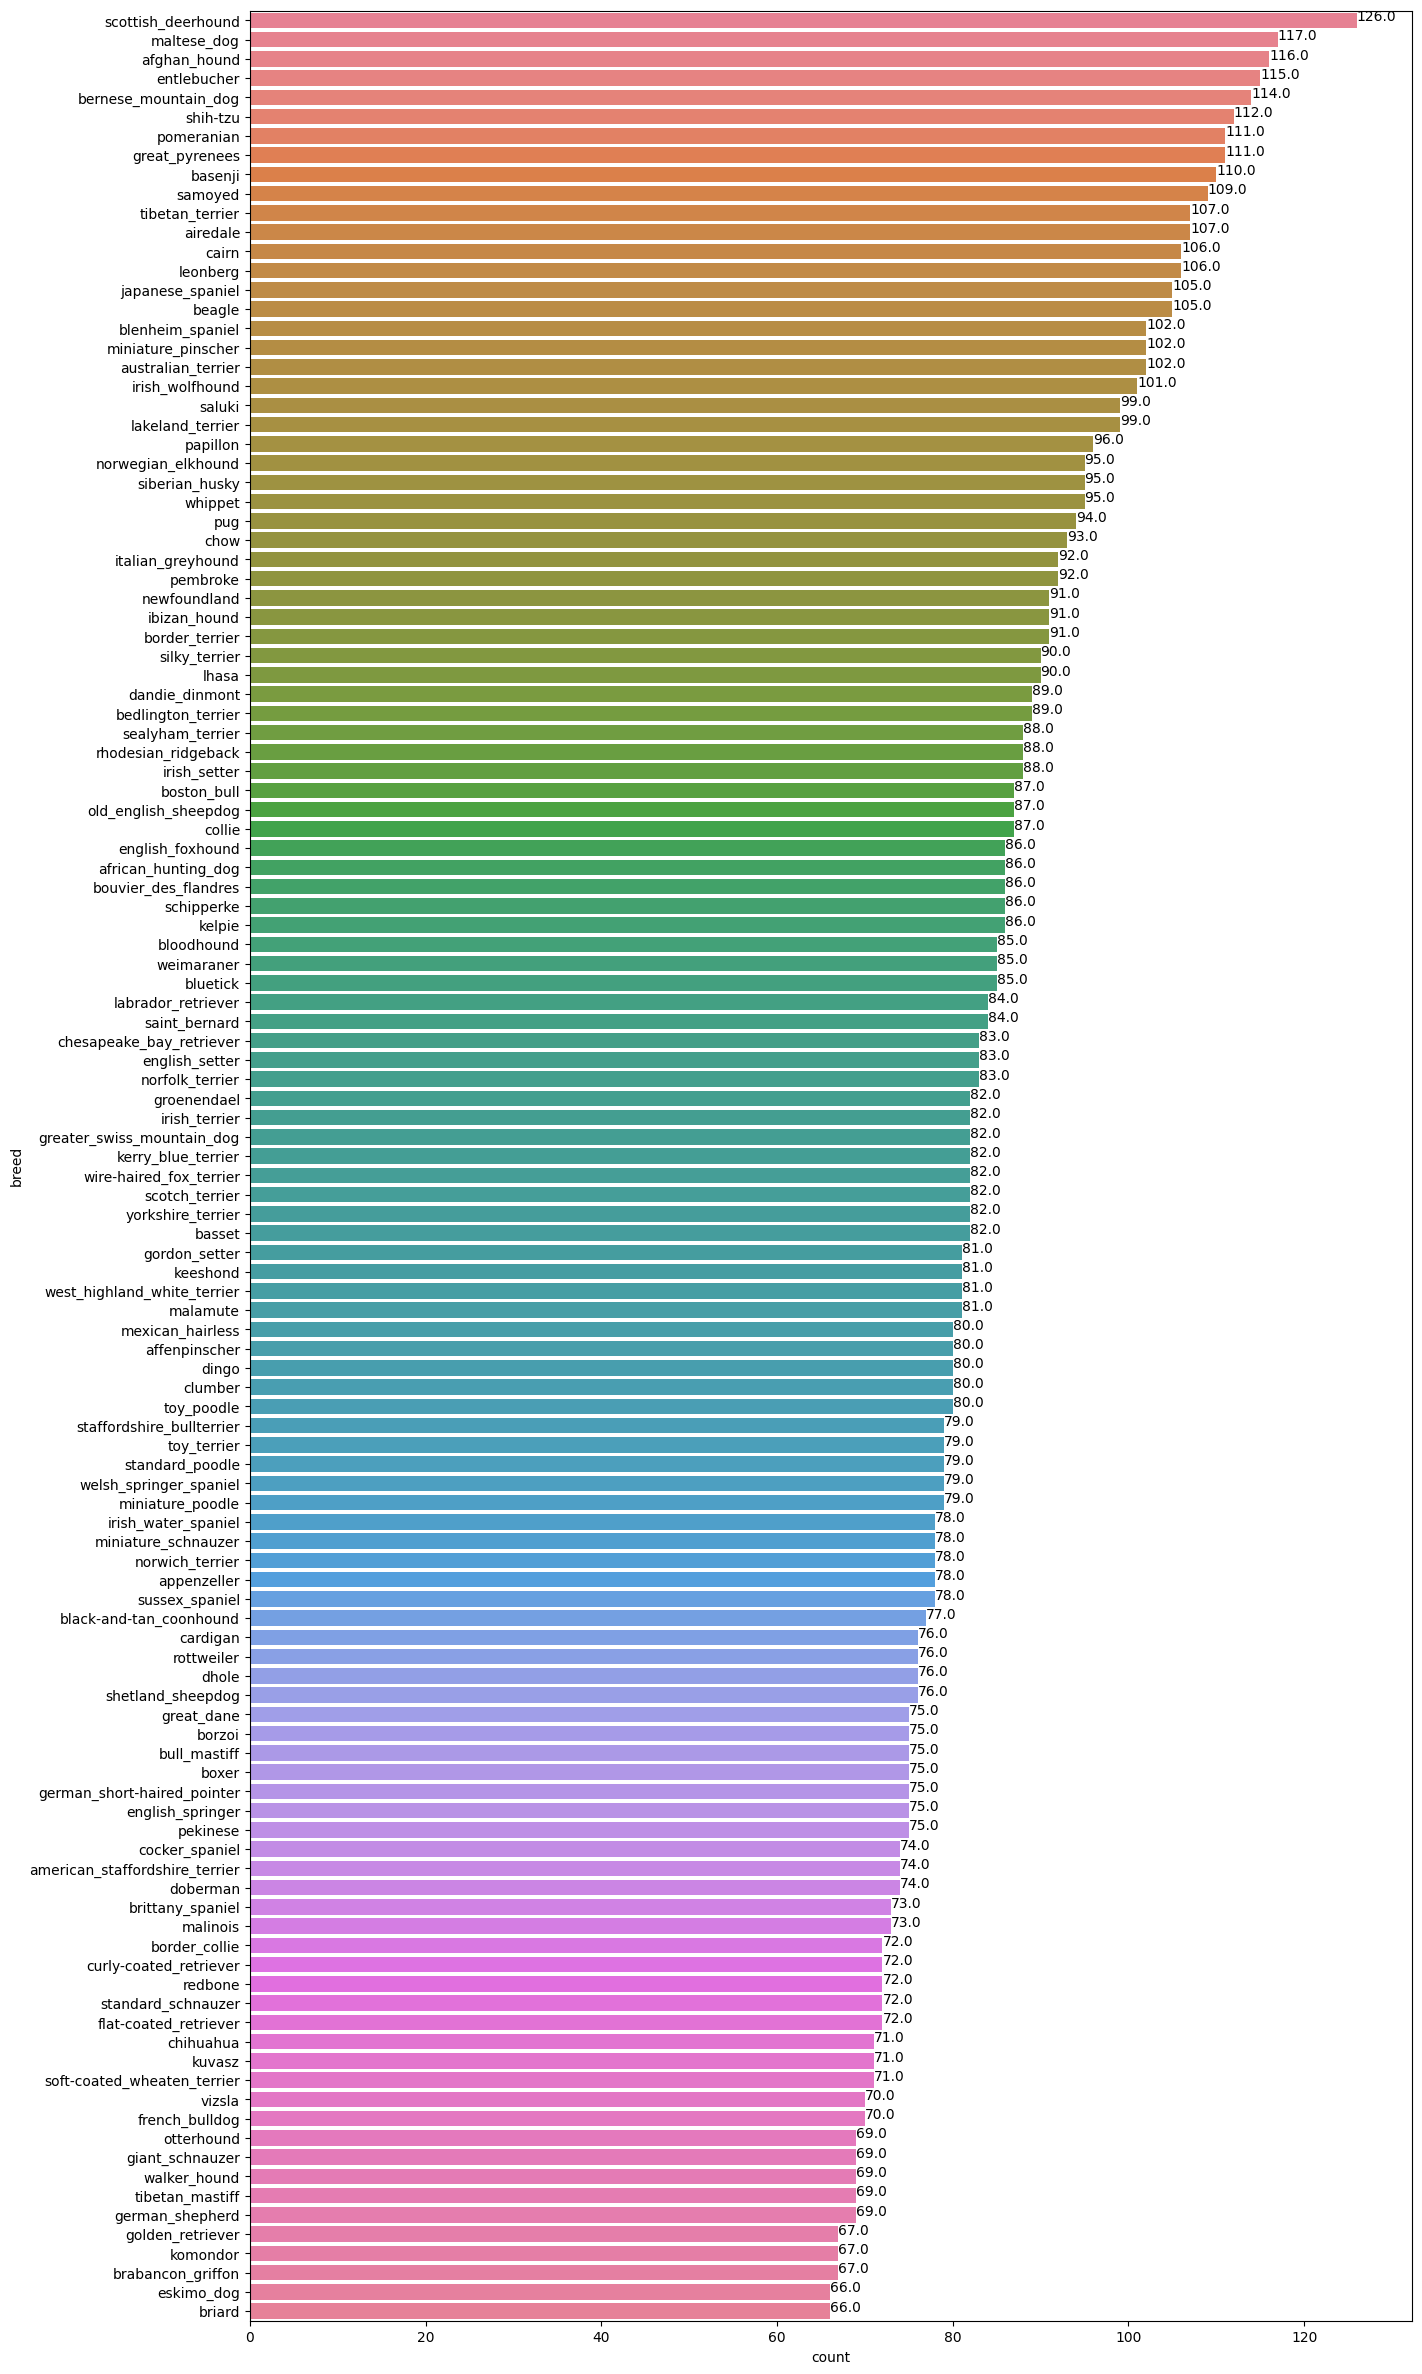

In [6]:
def barw(ax): 
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x-position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands
plt.figure(figsize = (15,30))
ax0 = sns.countplot(data=df, y='breed', order=df['breed'].value_counts().index, palette='husl')
# 'rainbow', 'Set3', 'husl', 'Paired', 'Spectral', 'RdYlBu', 'viridis' 
barw(ax0)
plt.show()

# Label Decoding


In [7]:
# 创建一个LabelEncoder()类
le = LabelEncoder() 
# .loc()使用标签进行选择；fit_transform学习（fit）所有不同的狗品种标签，并将每个品种转换为唯一的数字（transfrom）
df.loc[:, 'breed'] = le.fit_transform(df.loc[:, 'breed']) 
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


# Dog Breed Dataset

In [8]:
class Dog_Breed_Dataset(Dataset):
    
    def __init__(self, df:pd.DataFrame, img_base_path:str, split:str, transforms=None):
        self.df = df
        self.img_base_path = img_base_path
        self.split = split
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = os.path.join(self.img_base_path + self.df.loc[index,'id'] + '.jpg')
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)
        if self.split != "test":
            y = self.df.loc[index, 'breed']
            return img, y
        else:
            return img
    
    def __len__(self):
        return len(self.df)                

# Data Augmentation

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1 ,contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
simple_transforms = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare Data

将训练集和验证集划分为8:2

In [10]:
train, val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['breed']) # stratify确保训练集和验证集中各类别的比例保持一致
train = train.reset_index(drop=True) # 丢弃原来的索引，创建新的从0开始的连续索引
val   = val.reset_index(drop=True)

# Get DataLoader

In [11]:
train_dataloader = Dog_Breed_Dataset(train, img_base_path='/kaggle/input/dog-breed-identification-data/train/', split='train', transforms=train_transforms)
val_dataloader = Dog_Breed_Dataset(val, img_base_path='/kaggle/input/dog-breed-identification-data/train/', split='val', transforms=simple_transforms)

train_set = DataLoader(train_dataloader, batch_size=64, shuffle=True, num_workers=4)
val_set = DataLoader(val_dataloader, batch_size=64, shuffle=False, num_workers=4)

print(f'train_set length：{len(train_set.dataset)}\nval_set length：{len(val_set.dataset)}')

train_set length：8177
val_set length：2045


# Training Process

## Train Function

In [12]:
from tqdm import tqdm

In [13]:
def train_model(train_set, val_set, model, epochs=20):    
    
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    val_top3_acc_history = []
    val_top5_acc_history = []
    # 验证集上的最佳准确率
    best_val_loss = 1_000_000.0    
    # 获取初始权重
    weights = model.get_weights()
    
    for epoch in tqdm(range(epochs)):
        print("="*20, "Epoch: ", str(epoch), "="*20)
        
        train_correct_pred = 0
        val_correct_pred = 0
        val_top3_correct = 0
        val_top5_correct = 0
        train_acc = 0
        val_acc = 0
        train_loss = 0
        val_loss = 0
        
        # Training
        model.train()
        
        for x, y in train_set: # 一个批次                      
            x = x.clone().detach().to(device).requires_grad_(True)
            y = y.clone().detach().long().to(device)
            
            model.optim.zero_grad()
            
            preds = model(x)            
                    
            loss = model.criterion(preds,y) # criterion模型中定义的交叉熵损失            
                      
            loss.backward()
            model.optim.step()

            preds = torch.argmax(preds, dim=1) # 找出预测结果中概率最高的类别索引           
            train_correct_pred += (preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item() # .unsqueeze(1)在第1维添加一个维度，使形状匹配
            
            train_loss += loss.item() # .item()将Pytorch张量转换为Python标量           
        
        train_acc = train_correct_pred / len(train_set.dataset)
        
        train_acc_history.append(train_acc)
               
        train_loss_history.append(train_loss)
        
        # Valitation
        model.eval()      
        all_val_preds = []
        all_val_labels = []  
        
        with torch.no_grad():
            for x, y in val_set:                            
                x = x.clone().detach().to(device)
                y = y.clone().detach().long().to(device)    

                preds = model(x)                

                loss = model.criterion(preds,y)                                         
                
                val_loss += loss.item()                

                # 保存预测和标签用于后续评估
                all_val_preds.append(preds.cpu())
                all_val_labels.append(y.cpu())

                # Top-1准确率
                top1_preds = torch.argmax(preds, dim=1)
                val_correct_pred += (top1_preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item()
                
                # 计算Top-3和Top-5准确率
                _, top3_indices = torch.topk(preds, 3, dim=1)
                _, top5_indices = torch.topk(preds, 5, dim=1)
                
                # 检查真实标签是否在Top-3预测中
                for i, label in enumerate(y):
                    if label in top3_indices[i]:
                        val_top3_correct += 1
                    if label in top5_indices[i]:
                        val_top5_correct += 1
                
        model.scheduler.step() # 学习率调度器更新，在每个epoch后使用       
        
        val_acc = val_correct_pred / len(val_set.dataset)
        val_top3_acc = val_top3_correct / len(val_set.dataset)
        val_top5_acc = val_top5_correct / len(val_set.dataset)
        
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        val_top3_acc_history.append(val_top3_acc)
        val_top5_acc_history.append(val_top5_acc)
                   
        # 保存最佳模型的权重
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            weights = model.get_weights()
            
        print("Train acc: {:.4f} | Train Loss: {:.4f} | Validation acc: {:.4f} | Validation Loss: {:.4f}".format(train_acc, train_loss, val_acc, val_loss))
        print("Top-3 acc: {:.4f} | Top-5 acc: {:.4f}".format(val_top3_acc, val_top5_acc))
        
    # 加载最佳模型
    model.load_weights(weights)
    
    return [train_acc_history, train_loss_history, val_acc_history, val_loss_history, val_top3_acc_history, val_top5_acc_history], model, all_val_preds, all_val_labels

# Build Models

**Model 1：InceptionV3 model**  
1. 基本架构
- 由Google团队开发，2015年发表
- 是对Inception V1（GoogLeNet）和V2的改进
- 总参数量约2300万，比VGG、ResNet等模型更高效

2. 核心创新点
- 使用因式分解卷积：将nxn卷积替换为1xn和nx1卷积，减少计算量
- 辅助分类器（AuxLogits）：在网络中间层添加分支提供额外梯度，解决梯度消失问题
- 使用BatchNorm：提高训练稳定性和收敛速度
- 使用RMSProp优化器：相比SGD更自适应

3. Inception模块
- 核心思想：多尺度特征提取，平行使用不同大小的卷积核
- 包含1x1、3x3、5x5卷积和池化操作的并行组合
- 通过1x1卷积实现降维，减少计算量

4. 网络结构
- 输入：299x299x3的图像
- 包含多个Inception模块组
- 总深度约48层（取决于计算方式）
- 最后使用全局平均池化替代全连接层，减少参数


In [14]:
from torchvision.models import Inception_V3_Weights
inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
inception.AuxLogits # 访问Inception V3模型中的辅助分类器
"""
辅助分类器在训练早期阶段帮助加速网络收敛
梯度传播：为深层网络提供额外的梯度流，减轻梯度消失问题
正则化：起到一定的正则化作用，防止过拟合
"""

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 184MB/s] 


'\n辅助分类器在训练早期阶段帮助加速网络收敛\n梯度传播：为深层网络提供额外的梯度流，减轻梯度消失问题\n正则化：起到一定的正则化作用，防止过拟合\n'

In [15]:
for name, module in inception.named_children():
    print(name)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
maxpool1
Conv2d_3b_1x1
Conv2d_4a_3x3
maxpool2
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
AuxLogits
Mixed_7a
Mixed_7b
Mixed_7c
avgpool
dropout
fc


In [16]:
inception_model = nn.Sequential(
    inception.Conv2d_1a_3x3,
    inception.Conv2d_2a_3x3,
    inception.Conv2d_2b_3x3,
    inception.maxpool1,
    inception.Conv2d_3b_1x1,
    inception.Conv2d_4a_3x3,
    inception.maxpool2,
    inception.Mixed_5b, # 混合了多个不同类型的卷积操作，形成并行结构
    inception.Mixed_5c,
    inception.Mixed_5d,
    inception.Mixed_6a,
    inception.Mixed_6b,
    inception.Mixed_6c,
    inception.Mixed_6d,
    inception.Mixed_6e,
    # 跳过辅助层AuxLogits（在特征提取或迁移学习中，通常只需要网络的特征提取部分）
    inception.Mixed_7a,
    inception.Mixed_7b,
    inception.Mixed_7c,
    inception.avgpool
    # 跳过dropout层、全连接层fc（迁移学习时，目标任务的类别数量通常与预训练任务不同，需要替换分类层）
)
"""
Dropout层是一种正则化技术，在神经网络训练过程中随机暂时关闭一部分神经元。
具体来说，在每次训练迭代中，按照预设概率随机选择一些神经元，将它们的输出暂时设为零，使这些神经元在当前批次的前向和反向传播中不参与计算。
通过迫使网络不依赖于任何特定神经元，减少复杂的共适应关系，防止过拟合。
"""

'\nDropout层是一种正则化技术，在神经网络训练过程中随机暂时关闭一部分神经元。\n具体来说，在每次训练迭代中，按照预设概率随机选择一些神经元，将它们的输出暂时设为零，使这些神经元在当前批次的前向和反向传播中不参与计算。\n通过迫使网络不依赖于任何特定神经元，减少复杂的共适应关系，防止过拟合。\n'

**Model 2：Resnet 50**  
1. 基本架构
- 由微软研究院团队开发，2015年发表于CVPR
- 获得ILSVRC 2015分类任务冠军
- 50层深度的残差网络，约2500万参数

2. 核心创新点：残差学习
- 引入跳跃连接(Skip Connection)，构建残差块
- 解决了深层网络训练困难的问题（梯度消失/爆炸）
- 公式：H(x) = F(x) + x，让网络学习残差F(x)而非直接映射

3. 网络结构
- 初始卷积层：7x7卷积，stride=2
- 4个残差块组：分别包含3、4、6、3个残差块
- 每个残差块包含3个卷积层（1x1, 3x3, 1x1）
- 最后使用全局平均池化和全连接层

4. 瓶颈结构(Bottleneck)
- 使用1x1卷积进行降维和升维
- 三层结构：1x1降维 → 3x3卷积 → 1x1升维
- 显著减少计算量同时保持性能

In [17]:
from torchvision.models import ResNet50_Weights
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [18]:
for name, module in resnet50.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [19]:
resnet50_model = nn.Sequential(
    resnet50.conv1,
    resnet50.bn1,
    resnet50.relu,
    resnet50.maxpool,
    resnet50.layer1,
    resnet50.layer2,
    resnet50.layer3,
    resnet50.layer4,
    resnet50.avgpool
    # 跳过全连接层fc
)

`特征提取方法`：**完全冻结**预训练模型的特征提取网络  
- 使用预训练模型的特征提取能力，但只训练新添加的分类层
- 与"微调"(fine-tuning)方法相对，ft允许预训练模型的部分或全部参数更新

In [20]:
for param in resnet50_model.parameters():    
    param.requires_grad = False # 在反向传播过程中，这些参数不需要计算梯度，也就不会被优化器更新
    
for param in inception_model.parameters():    
    param.requires_grad = False

### Model Class

In [21]:
class Model(nn.Module):

    def __init__(self, inception_model, resnet50_model, epochs=20):
        super(Model,self).__init__() # 初始化父类
        
        self.inception_model = inception_model
        self.resnet50_model = resnet50_model        
        
        self.output = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(4096,120) # 输入维度为4096，输出维度为120（breeds），将提取的特征映射到最终的类别概率            
        ) # simple fc layer
        
        self.to(device)
        # Optimizer 优化器
        self.optim = torch.optim.AdamW(self.output.parameters(), lr=1e-4, weight_decay=1e-4) 
        # Loss 使用交叉损失
        self.criterion = torch.nn.CrossEntropyLoss()
        # Scheduler 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optim, T_max=epochs, eta_min=1e-6)
        
    def forward(self, x):
        X1 = self.inception_model(x)
        X2 = self.resnet50_model(x)
        
        # 将多维特征张量 reshape 为二维张量，第一维保持不变，其余维度合并，-1自动计算这一维的大小
        # 例如，如果X1形状是[64, 2048, 1, 1](批次大小, 通道数, 高, 宽)，调用后变为[64, 2048]
        X1 = X1.view(X1.size(0), -1) # resize to (batchsize, -1)
        X2 = X2.view(X2.size(0), -1) # resize to (batchsize, -1)

        # 特征融合feature fusion/集成学习ensemble
        X = torch.cat([X1, X2], dim=1) # 在特征维度(第二维)上连接，保持批次维度不变
        # 例X1形状为[64, 2048](InceptionV3特征），如果X2形状为[64, 2048](ResNet50特征)，连接后X形状为[64, 4096]，前2048个特征来自InceptionV3，后2048个来自ResNet50
         
        P = self.output(X)        
        
        return P
    
    def get_weights(self):
        return self.output.state_dict() # 保存模型的权重参数
    
    def load_weights(self, weights):
        self.output.load_state_dict(weights) # 加载保存的权重参数到模型的分类器部分

## Start training

In [22]:
print(torch.__version__)  # 查看当前版本
print(torch.version.cuda) # 查看CUDA版本
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")

2.5.1+cu124
12.4
Current device: 0
Device name: Tesla P100-PCIE-16GB


In [23]:
model = Model(inception_model, resnet50_model)

In [24]:
history, model, all_val_preds, all_val_labels = train_model(train_set, val_set, model)

  0%|          | 0/20 [00:00<?, ?it/s]

==================== Epoch:  0 ====================


  5%|▌         | 1/20 [01:10<22:25, 70.82s/it]

Train acc: 0.1713 | Train Loss: 561.3075 | Validation acc: 0.5017 | Validation Loss: 121.7735
Top-3 acc: 0.7169 | Top-5 acc: 0.8020
==================== Epoch:  1 ====================


 10%|█         | 2/20 [02:19<20:49, 69.43s/it]

Train acc: 0.4925 | Train Loss: 453.3243 | Validation acc: 0.6553 | Validation Loss: 97.5455
Top-3 acc: 0.8543 | Top-5 acc: 0.9037
==================== Epoch:  2 ====================


 15%|█▌        | 3/20 [03:27<19:31, 68.92s/it]

Train acc: 0.6024 | Train Loss: 373.5508 | Validation acc: 0.6914 | Validation Loss: 78.9790
Top-3 acc: 0.8900 | Top-5 acc: 0.9311
==================== Epoch:  3 ====================


 20%|██        | 4/20 [04:36<18:19, 68.74s/it]

Train acc: 0.6667 | Train Loss: 312.7622 | Validation acc: 0.7169 | Validation Loss: 66.2340
Top-3 acc: 0.9056 | Top-5 acc: 0.9462
==================== Epoch:  4 ====================


 25%|██▌       | 5/20 [05:44<17:09, 68.64s/it]

Train acc: 0.7016 | Train Loss: 272.3507 | Validation acc: 0.7374 | Validation Loss: 58.1956
Top-3 acc: 0.9159 | Top-5 acc: 0.9477
==================== Epoch:  5 ====================


 30%|███       | 6/20 [06:52<15:59, 68.54s/it]

Train acc: 0.7314 | Train Loss: 240.9975 | Validation acc: 0.7535 | Validation Loss: 51.1314
Top-3 acc: 0.9198 | Top-5 acc: 0.9511
==================== Epoch:  6 ====================


 35%|███▌      | 7/20 [08:01<14:50, 68.53s/it]

Train acc: 0.7450 | Train Loss: 219.8239 | Validation acc: 0.7599 | Validation Loss: 47.2611
Top-3 acc: 0.9281 | Top-5 acc: 0.9565
==================== Epoch:  7 ====================


 40%|████      | 8/20 [09:09<13:42, 68.53s/it]

Train acc: 0.7634 | Train Loss: 204.4927 | Validation acc: 0.7682 | Validation Loss: 44.3589
Top-3 acc: 0.9281 | Top-5 acc: 0.9545
==================== Epoch:  8 ====================


 45%|████▌     | 9/20 [10:18<12:33, 68.46s/it]

Train acc: 0.7701 | Train Loss: 191.7754 | Validation acc: 0.7726 | Validation Loss: 41.1160
Top-3 acc: 0.9311 | Top-5 acc: 0.9628
==================== Epoch:  9 ====================


 50%|█████     | 10/20 [11:26<11:24, 68.49s/it]

Train acc: 0.7730 | Train Loss: 183.1094 | Validation acc: 0.7785 | Validation Loss: 39.9907
Top-3 acc: 0.9330 | Top-5 acc: 0.9604
==================== Epoch:  10 ====================


 55%|█████▌    | 11/20 [12:35<10:17, 68.64s/it]

Train acc: 0.7908 | Train Loss: 173.6826 | Validation acc: 0.7770 | Validation Loss: 38.3678
Top-3 acc: 0.9311 | Top-5 acc: 0.9638
==================== Epoch:  11 ====================


 60%|██████    | 12/20 [13:44<09:09, 68.72s/it]

Train acc: 0.7846 | Train Loss: 168.9062 | Validation acc: 0.7844 | Validation Loss: 36.9576
Top-3 acc: 0.9335 | Top-5 acc: 0.9672
==================== Epoch:  12 ====================


 65%|██████▌   | 13/20 [14:53<08:00, 68.62s/it]

Train acc: 0.7969 | Train Loss: 162.8832 | Validation acc: 0.7848 | Validation Loss: 36.5432
Top-3 acc: 0.9364 | Top-5 acc: 0.9658
==================== Epoch:  13 ====================


 70%|███████   | 14/20 [16:01<06:51, 68.58s/it]

Train acc: 0.8047 | Train Loss: 159.0611 | Validation acc: 0.7848 | Validation Loss: 35.7846
Top-3 acc: 0.9355 | Top-5 acc: 0.9667
==================== Epoch:  14 ====================


 75%|███████▌  | 15/20 [17:10<05:43, 68.63s/it]

Train acc: 0.7977 | Train Loss: 158.4483 | Validation acc: 0.7848 | Validation Loss: 35.7210
Top-3 acc: 0.9389 | Top-5 acc: 0.9672
==================== Epoch:  15 ====================


 80%|████████  | 16/20 [18:19<04:34, 68.68s/it]

Train acc: 0.8075 | Train Loss: 154.5268 | Validation acc: 0.7883 | Validation Loss: 35.5008
Top-3 acc: 0.9369 | Top-5 acc: 0.9663
==================== Epoch:  16 ====================


 85%|████████▌ | 17/20 [19:27<03:25, 68.64s/it]

Train acc: 0.8113 | Train Loss: 153.3864 | Validation acc: 0.7873 | Validation Loss: 35.3287
Top-3 acc: 0.9364 | Top-5 acc: 0.9658
==================== Epoch:  17 ====================


 90%|█████████ | 18/20 [20:36<02:17, 68.60s/it]

Train acc: 0.8075 | Train Loss: 153.9144 | Validation acc: 0.7897 | Validation Loss: 34.6849
Top-3 acc: 0.9389 | Top-5 acc: 0.9667
==================== Epoch:  18 ====================


 95%|█████████▌| 19/20 [21:44<01:08, 68.60s/it]

Train acc: 0.8084 | Train Loss: 153.3699 | Validation acc: 0.7873 | Validation Loss: 34.8697
Top-3 acc: 0.9374 | Top-5 acc: 0.9672
==================== Epoch:  19 ====================


100%|██████████| 20/20 [22:53<00:00, 68.65s/it]

Train acc: 0.8126 | Train Loss: 151.6138 | Validation acc: 0.7892 | Validation Loss: 34.9407
Top-3 acc: 0.9394 | Top-5 acc: 0.9653


## Training and Validation Results


In [25]:
# 处理验证集的预测结果以进行详细评估
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# 获取最终预测
final_preds = torch.argmax(all_val_preds, dim=1).numpy()
true_labels = all_val_labels.numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, final_preds)

# 计算每个类别的精确率、召回率和F1分数
precision, recall, f1, support = precision_recall_fscore_support(true_labels, final_preds, average=None)
weighted_f1 = f1_score(true_labels, final_preds, average='weighted')

# 将类别从数字转回名称
breed_names = le.inverse_transform(np.unique(true_labels))

Visualization

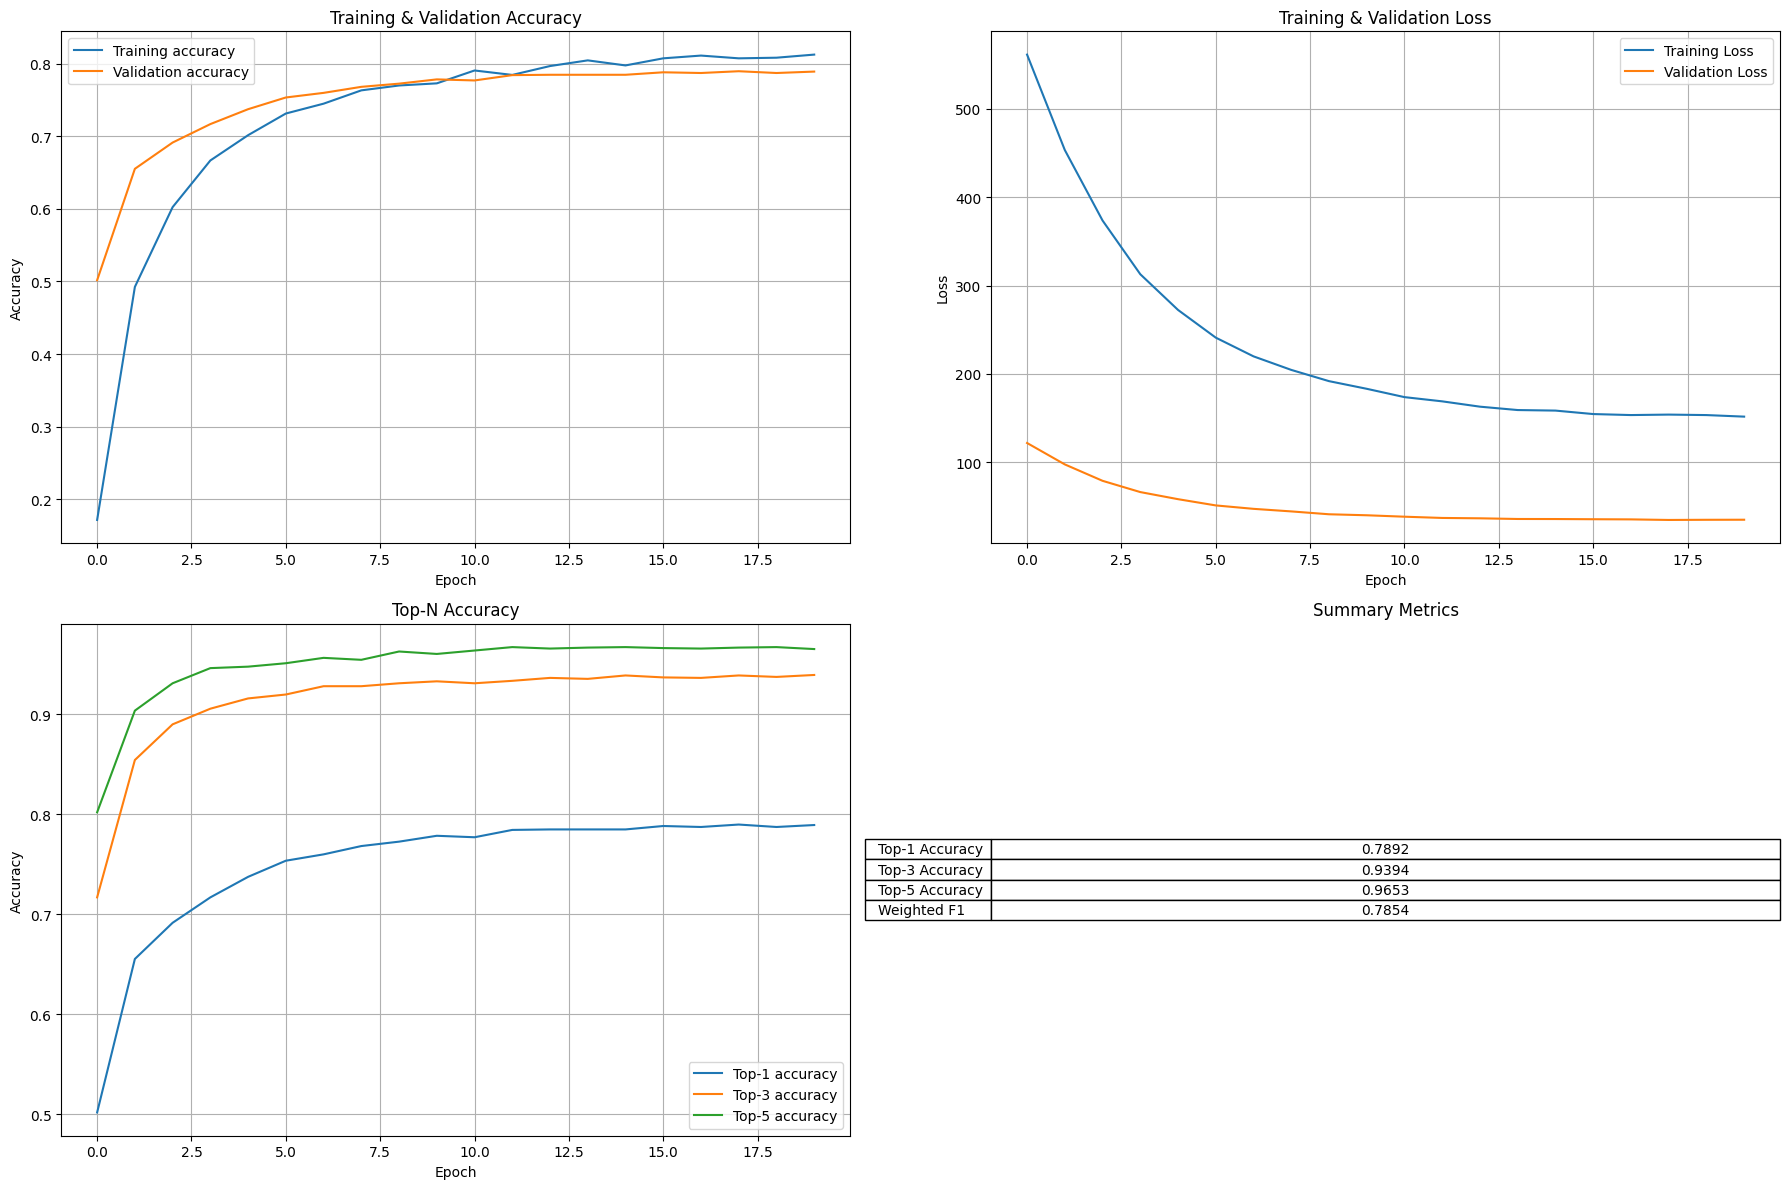

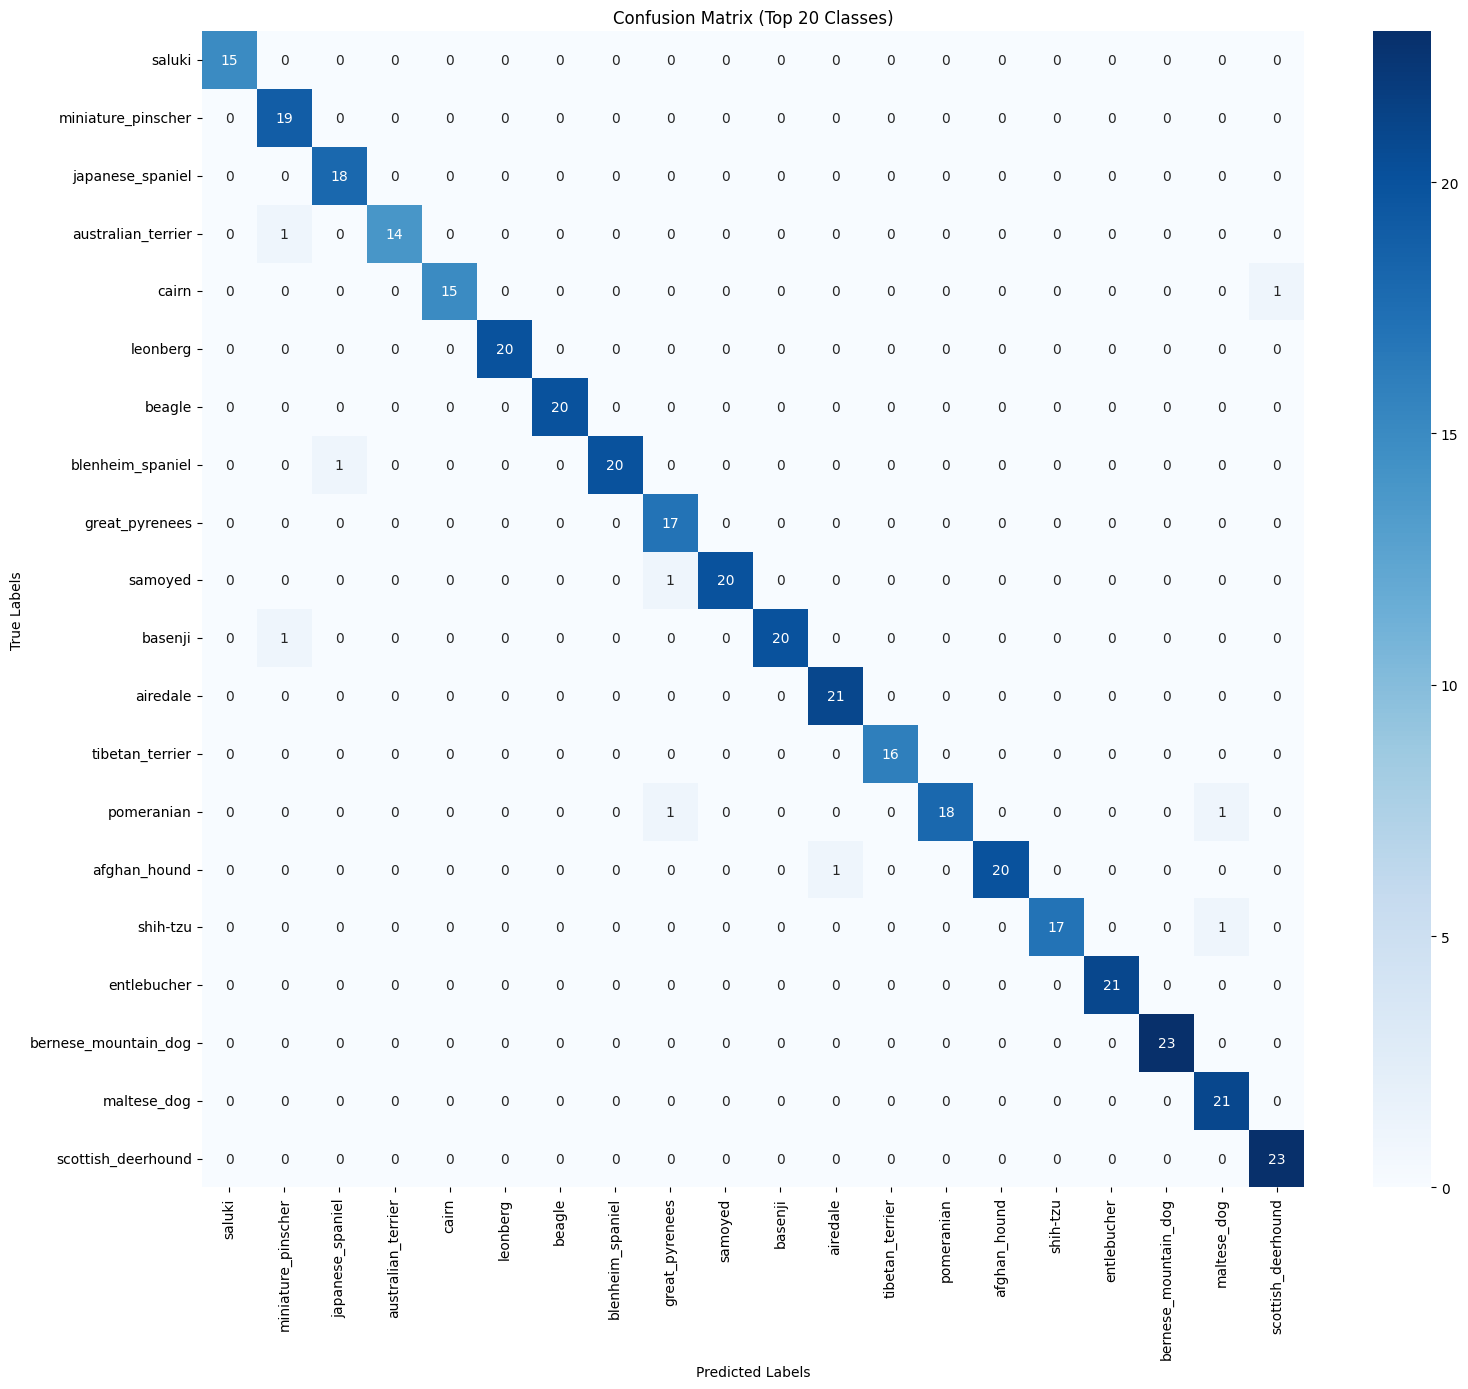

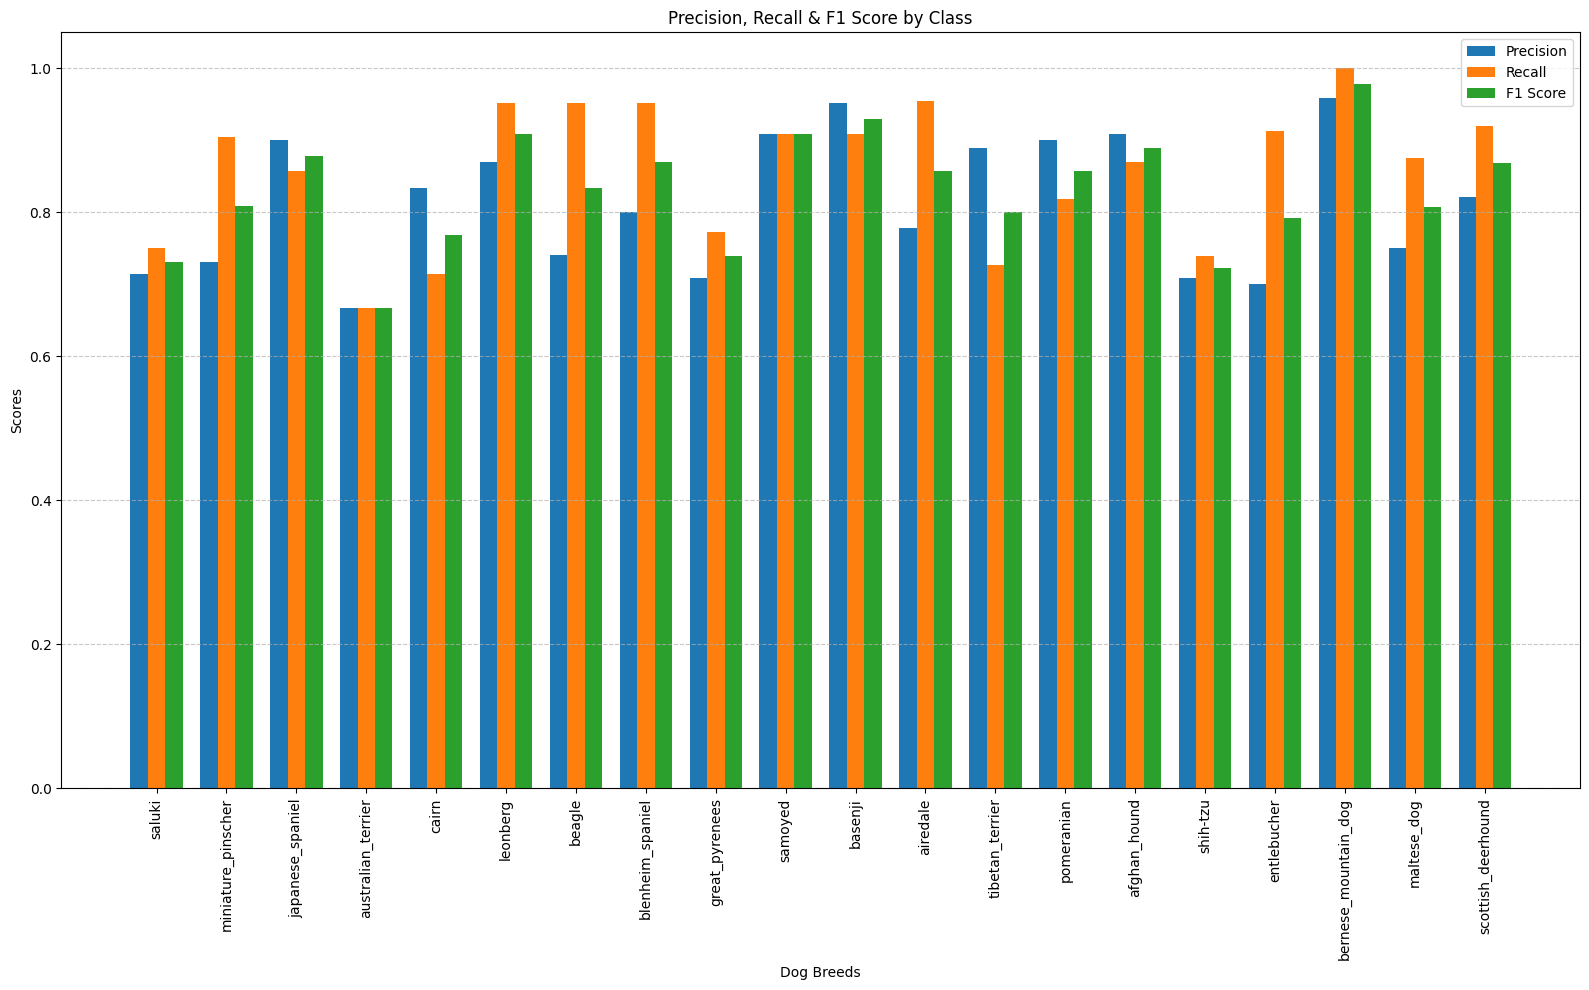

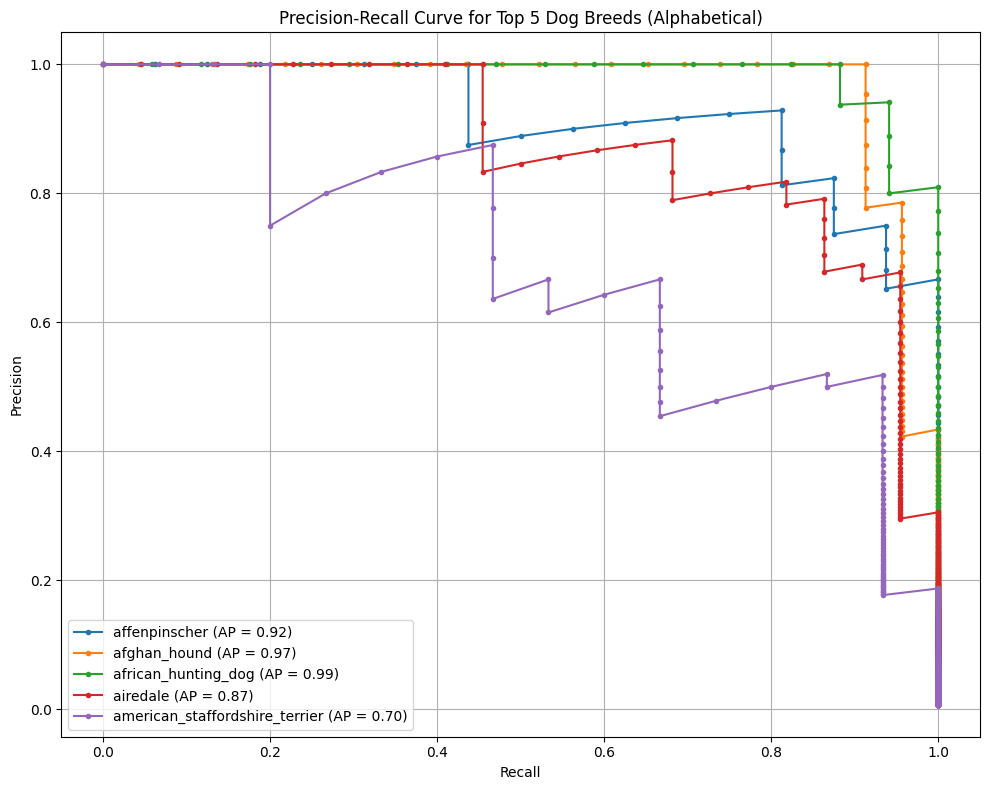

Overall weighted F1 score: 0.7854
Final validation accuracy: 0.7892
Top-3 accuracy: 0.9394
Top-5 accuracy: 0.9653


In [26]:
# 1. Training and Validation Results (Accuracy & Loss)
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Accuracy
axs[0, 0].plot(range(20), history[0], label="Training accuracy")
axs[0, 0].plot(range(20), history[2], label="Validation accuracy")
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Training & Validation Accuracy')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Loss
axs[0, 1].plot(range(20), history[1], label="Training Loss")
axs[0, 1].plot(range(20), history[3], label="Validation Loss")
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Training & Validation Loss')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Top-3 & Top-5 Accuracy
axs[1, 0].plot(range(20), history[2], label="Top-1 accuracy")
axs[1, 0].plot(range(20), history[4], label="Top-3 accuracy")
axs[1, 0].plot(range(20), history[5], label="Top-5 accuracy")
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Top-N Accuracy')
axs[1, 0].grid(True)
axs[1, 0].legend()

# 综合评估指标
metrics_summary = {
    'Metric': ['Top-1 Accuracy', 'Top-3 Accuracy', 'Top-5 Accuracy', 'Weighted F1'],
    'Value': [history[2][-1], history[4][-1], history[5][-1], weighted_f1]
}
axs[1, 1].axis('off')
axs[1, 1].table(cellText=[[f"{val:.4f}"] for val in metrics_summary['Value']],
                rowLabels=metrics_summary['Metric'],
                loc='center',
                cellLoc='center')
axs[1, 1].set_title('Summary Metrics')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# 2. 绘制混淆矩阵热力图
# 只选择前20个类别
if len(breed_names) > 20:
    # 通过支持度(support)排序，选择样本最多的20个类别
    top_classes_idx = np.argsort(support)[-20:]
    selected_conf_matrix = conf_matrix[top_classes_idx][:, top_classes_idx]
    selected_breed_names = breed_names[top_classes_idx]
else:
    selected_conf_matrix = conf_matrix
    selected_breed_names = breed_names

plt.figure(figsize=(16, 14))
sns.heatmap(selected_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_breed_names,
            yticklabels=selected_breed_names)
plt.title('Confusion Matrix (Top 20 Classes)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 3. 每个类别的精确率和召回率
# 只选择前20个类别
if len(breed_names) > 20:
    top_classes_idx = np.argsort(support)[-20:]
    selected_precision = precision[top_classes_idx]
    selected_recall = recall[top_classes_idx]
    selected_f1 = f1[top_classes_idx]
    selected_breed_names = breed_names[top_classes_idx]
else:
    selected_precision = precision
    selected_recall = recall
    selected_f1 = f1
    selected_breed_names = breed_names
    
# 创建精确率和召回率的对比图
plt.figure(figsize=(16, 10))
x = np.arange(len(selected_breed_names))
width = 0.25

plt.bar(x - width, selected_precision, width, label='Precision')
plt.bar(x, selected_recall, width, label='Recall')
plt.bar(x + width, selected_f1, width, label='F1 Score')

plt.xlabel('Dog Breeds')
plt.ylabel('Scores')
plt.title('Precision, Recall & F1 Score by Class')
plt.xticks(x, selected_breed_names, rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('precision_recall_f1.png')
plt.show()

# 4. 绘制前五个类别（按字母排序）的 PR 曲线
# 获取概率输出
val_probs = torch.softmax(all_val_preds, dim=1).numpy()
# 将真实标签进行 one-hot 编码
n_classes = len(dog_breeds) # 使用已排序的 dog_breeds
classes_indices = np.arange(n_classes)
y_true_bin = label_binarize(true_labels, classes=classes_indices)

# 获取前五个类别名称及其对应的索引
top_5_breed_names = dog_breeds[:5]
top_5_indices = le.transform(top_5_breed_names) # 获取这些名称对应的数字标签

plt.figure(figsize=(10, 8))

for i, breed_name in zip(top_5_indices, top_5_breed_names):
    # 计算该类别的精确率、召回率和阈值 (One-vs-Rest)
    precision_class, recall_class, _ = precision_recall_curve(y_true_bin[:, i], val_probs[:, i])
    # 计算该类别的 AP
    ap_class = average_precision_score(y_true_bin[:, i], val_probs[:, i])
    # 绘制 PR 曲线
    plt.plot(recall_class, precision_class, marker='.', label=f'{breed_name} (AP = {ap_class:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Top 5 Dog Breeds (Alphabetical)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('top5_precision_recall_curve.png')
plt.show()

# 输出整体指标
print(f"Overall weighted F1 score: {weighted_f1:.4f}")
print(f"Final validation accuracy: {history[2][-1]:.4f}")
print(f"Top-3 accuracy: {history[4][-1]:.4f}")
print(f"Top-5 accuracy: {history[5][-1]:.4f}")

# Testing Process

## Read test data

In [27]:
# 移除所有测试图像的".jpg"扩展名，并将它们存储在一个DataFrame中
test_data = pd.DataFrame([])
for dirname, _, filename in os.walk('/kaggle/input/dog-breed-identification-data/test'):
    filename = pd.Series(filename)
    test_data = pd.concat([test_data, filename], axis=0)
test_data.columns = ['id']
test_data['id'] = test_data['id'].str.replace(".jpg","")

print(f"Test dataset shape: {test_data.shape}")
test_data.head()

Test dataset shape: (10357, 1)


,id
0,09e51e17e2b756ff2ace8a87bd1443fa
1,f7a32505c12649183c5991ecfa7d68b3
2,bc6d50ffb4644feb34530aa58943e85b
3,7cbc041e79135a572aad87904b5c9c57
4,f3b603f10d6a344f0395fb46b242ff8e


## Get Test DataLoader

In [28]:
test_dataset = Dog_Breed_Dataset(
    df=test_data,
    img_base_path='/kaggle/input/dog-breed-identification-data/test/',
    split='test',
    transforms=simple_transforms
)

test_set = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

## Test Function

In [29]:
def test_model(test_set, model):       
    
    prob_preds = pd.DataFrame([])

    # 使用 tqdm 显示测试进度
    for x in tqdm(test_set, desc="Testing"):
                
        x = x.clone().detach().to(device)            

        pred = model(x)  
        prob_pred = torch.nn.functional.softmax(pred, dim=1) # softmax将原始分数转换为概率分布，dim=1指定在类别维度上应用softmax
            
        prob_pred = prob_pred.detach().cpu().numpy()             
        prob_pred = pd.DataFrame(prob_pred) # 每一行代表一张图像，每一列代表一个类别，单元格的值是对应的预测概率
            
        prob_preds = pd.concat([prob_preds, prob_pred], axis=0) 
            
    return prob_preds       

## Start testing

In [30]:
test_preds = test_model(test_set, model)

Testing: 100%|██████████| 162/162 [00:35<00:00,  4.51it/s]


In [31]:
test_preds.shape
test_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000443,0.000075,0.001098,0.000547,0.271720,0.000783,0.001087,0.001052,0.000385,0.000839,...,0.001062,0.000984,0.000995,0.000593,0.000979,0.000218,0.003316,0.001305,0.000778,0.001442
1,0.000219,0.000454,0.000097,0.001267,0.001366,0.000686,0.000686,0.001789,0.011765,0.001891,...,0.000787,0.000393,0.076651,0.001640,0.001320,0.001120,0.000143,0.000948,0.000398,0.000804
2,0.000149,0.006723,0.000029,0.000618,0.000116,0.000110,0.000237,0.000057,0.000119,0.000131,...,0.000237,0.000065,0.000027,0.000073,0.000039,0.000590,0.000047,0.000217,0.000092,0.000221
3,0.000265,0.000360,0.000780,0.000903,0.008410,0.000865,0.000355,0.003839,0.001193,0.000569,...,0.000491,0.004854,0.002103,0.000802,0.060009,0.000621,0.000636,0.172540,0.001463,0.000331
4,0.000050,0.000311,0.000152,0.000542,0.000665,0.001385,0.000220,0.000952,0.009642,0.003273,...,0.000190,0.000371,0.000366,0.005207,0.000205,0.828044,0.000286,0.001005,0.001223,0.000193


每种类别的数字id转换回标签值

In [32]:
num_classes = []
for num_class in test_preds.columns:
    num_classes.append(num_class)

num_classes = np.array(num_classes) # inverse_transform需要Numpy数组或类似结构
num_classes = le.inverse_transform(num_classes)
test_preds.columns = list(num_classes)

test_preds.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000443,0.000075,0.001098,0.000547,0.271720,0.000783,0.001087,0.001052,0.000385,0.000839,...,0.001062,0.000984,0.000995,0.000593,0.000979,0.000218,0.003316,0.001305,0.000778,0.001442
1,0.000219,0.000454,0.000097,0.001267,0.001366,0.000686,0.000686,0.001789,0.011765,0.001891,...,0.000787,0.000393,0.076651,0.001640,0.001320,0.001120,0.000143,0.000948,0.000398,0.000804
2,0.000149,0.006723,0.000029,0.000618,0.000116,0.000110,0.000237,0.000057,0.000119,0.000131,...,0.000237,0.000065,0.000027,0.000073,0.000039,0.000590,0.000047,0.000217,0.000092,0.000221
3,0.000265,0.000360,0.000780,0.000903,0.008410,0.000865,0.000355,0.003839,0.001193,0.000569,...,0.000491,0.004854,0.002103,0.000802,0.060009,0.000621,0.000636,0.172540,0.001463,0.000331
4,0.000050,0.000311,0.000152,0.000542,0.000665,0.001385,0.000220,0.000952,0.009642,0.003273,...,0.000190,0.000371,0.000366,0.005207,0.000205,0.828044,0.000286,0.001005,0.001223,0.000193


转换为要求提交的格式

In [33]:
test_preds = test_preds.reset_index(drop=True)
ids = test_data.loc[:,'id']
test_preds = pd.concat([ids, test_preds], axis=1)
test_preds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,0.000443,0.000075,0.001098,0.000547,0.271720,0.000783,0.001087,0.001052,0.000385,...,0.001062,0.000984,0.000995,0.000593,0.000979,0.000218,0.003316,0.001305,0.000778,0.001442
1,f7a32505c12649183c5991ecfa7d68b3,0.000219,0.000454,0.000097,0.001267,0.001366,0.000686,0.000686,0.001789,0.011765,...,0.000787,0.000393,0.076651,0.001640,0.001320,0.001120,0.000143,0.000948,0.000398,0.000804
2,bc6d50ffb4644feb34530aa58943e85b,0.000149,0.006723,0.000029,0.000618,0.000116,0.000110,0.000237,0.000057,0.000119,...,0.000237,0.000065,0.000027,0.000073,0.000039,0.000590,0.000047,0.000217,0.000092,0.000221
3,7cbc041e79135a572aad87904b5c9c57,0.000265,0.000360,0.000780,0.000903,0.008410,0.000865,0.000355,0.003839,0.001193,...,0.000491,0.004854,0.002103,0.000802,0.060009,0.000621,0.000636,0.172540,0.001463,0.000331
4,f3b603f10d6a344f0395fb46b242ff8e,0.000050,0.000311,0.000152,0.000542,0.000665,0.001385,0.000220,0.000952,0.009642,...,0.000190,0.000371,0.000366,0.005207,0.000205,0.828044,0.000286,0.001005,0.001223,0.000193


生成提交文件

In [34]:
test_preds.to_csv('submission.csv', index=None)